In [3]:
# Necessary dependency for the Bertweet preprocessor to encode emojis
# !pip3 install emoji

import json
import numpy as np
import pandas as pd
from transformers import TFAutoModel, BertTokenizerFast, AutoTokenizer
from datetime import datetime, timedelta
import tensorflow as tf
import requests
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

tweets_file_path = "drive/MyDrive/fatma-nlp/tweets"

# 0. Candidate language models to use for tweet sentiment analysis

In [4]:
# https://github.com/cardiffnlp/tweeteval

# Candidate models to use:
# Have a look at VADER (Valence Aware dictionnary and sEntiment Reasoner)
    # Rule-based sentiment analysis. Specifically suited for social media text
# TODO: Have a look at https://huggingface.co/docs/transformers/model_doc/bertweet
# TODO: Check this one: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
    # General tweet (not specifically crypto/ btc related) sentiments

# For our project, we decided to work with Bertweet
model_name = 'vinai/bertweet-base'

# 1. Load and explore the data

In [5]:
def load_tweets_from_file(filename):
    with open(filename, "r", encoding='utf-8') as file:
        json_object = json.load(file)
    return json_object["tweets"]

json_object = load_tweets_from_file(tweets_file_path)
df = pd.json_normalize(json_object)

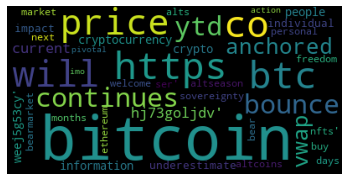

In [6]:
# Visualize Word Cloud
text = df['content'].values
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [7]:
# Index the dataframe by date to allow slicing by datetimes
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
print("Data types:\n", df.dtypes)
df

Data types:
 content           object
replyCount         int64
retweetCount       int64
likeCount          int64
quoteCount         int64
lang              object
verified            bool
followersCount     int64
friendsCount       int64
statusesCount      int64
dtype: object


,content,replyCount,retweetCount,likeCount,quoteCount,lang,verified,followersCount,friendsCount,statusesCount
date,,,,,,,,,,
2022-01-01 00:00:00+00:00,$btc continues to bounce off the ytd anchored ...,0,0,20,0,en,True,203116,1400,53551
2022-01-01 00:00:00+00:00,current price of bitcoin: $46320 (-1.85%) $btc...,0,0,0,0,en,False,67,65,1759
2022-01-01 00:00:02+00:00,most people underestimate the impact #bitcoin ...,20,31,211,3,en,True,245622,750,18051
2022-01-01 00:00:02+00:00,"bitcoin - btc price: $46,306.45 change in 1h: ...",0,0,0,0,en,False,4609,0,380423
2022-01-01 00:00:02+00:00,"#bitcoin is currently $46,230.6131",0,0,0,0,en,False,24,0,7023
...,...,...,...,...,...,...,...,...,...,...
2022-01-30 23:59:00+00:00,"candle of day 30/01/2022 closed. open: $ 38,20...",0,0,0,0,en,False,35,5,407
2022-01-30 23:59:06+00:00,#bitcoin is trying to get over $38.5k here. be...,0,0,1,0,en,False,13,4,189
2022-01-30 23:59:09+00:00,buy more #bitcoin ser,0,0,1,0,en,False,865,1688,7818


In [8]:
# Explore some tweets sliced by datetimes
df.loc['2022-01-01 00:00:00':'2022-01-01 01:00:00']

,content,replyCount,retweetCount,likeCount,quoteCount,lang,verified,followersCount,friendsCount,statusesCount
date,,,,,,,,,,
2022-01-01 00:00:00+00:00,$btc continues to bounce off the ytd anchored ...,0,0,20,0,en,True,203116,1400,53551
2022-01-01 00:00:00+00:00,current price of bitcoin: $46320 (-1.85%) $btc...,0,0,0,0,en,False,67,65,1759
2022-01-01 00:00:02+00:00,most people underestimate the impact #bitcoin ...,20,31,211,3,en,True,245622,750,18051
2022-01-01 00:00:02+00:00,"bitcoin - btc price: $46,306.45 change in 1h: ...",0,0,0,0,en,False,4609,0,380423
2022-01-01 00:00:02+00:00,"#bitcoin is currently $46,230.6131",0,0,0,0,en,False,24,0,7023
...,...,...,...,...,...,...,...,...,...,...
2022-01-01 00:59:06+00:00,my biggest qualm about #bitcoin is not whether...,0,0,0,0,en,False,5,48,70
2022-01-01 00:59:21+00:00,time for the god #bitcoin candles,0,0,1,0,en,False,2401,244,3077
2022-01-01 00:59:39+00:00,"1 bitcoin ( #btc ) dollar: 46,649.32$ 1 bitcoi...",1,1,0,0,en,False,5746,4,19822


# 2. Clean the data

In [9]:
df = df[df.likeCount != 0]
df = df[df.followersCount != 0]
df = df.drop(columns=["lang"], axis=1)
df

,content,replyCount,retweetCount,likeCount,quoteCount,verified,followersCount,friendsCount,statusesCount
date,,,,,,,,,
2022-01-01 00:00:00+00:00,$btc continues to bounce off the ytd anchored ...,0,0,20,0,True,203116,1400,53551
2022-01-01 00:00:02+00:00,most people underestimate the impact #bitcoin ...,20,31,211,3,True,245622,750,18051
2022-01-01 00:00:03+00:00,bitcoin faces a year-end technical test after ...,0,4,4,0,False,1824,171,10524
2022-01-01 00:00:06+00:00,crypto in 2021: a year in review (part 4) #bit...,0,0,1,0,False,6994,606,77904
2022-01-01 00:00:38+00:00,pump it #bitcoin,0,1,1,0,False,411,466,2049
...,...,...,...,...,...,...,...,...,...
2022-01-30 23:56:31+00:00,5 min left to go to close the week into the gr...,0,0,1,0,False,1457,4980,11432
2022-01-30 23:56:53+00:00,#bitcoin white house executive order. probably...,0,0,1,0,False,26,85,909
2022-01-30 23:59:06+00:00,#bitcoin is trying to get over $38.5k here. be...,0,0,1,0,False,13,4,189


# 3. Prepare the data for training

### Slice tweets according to time windows

In [10]:
def slice_by_time_windows(df, start_date, end_date, window_seconds=0, window_minutes=0, window_hours=0):
    assert window_seconds or window_minutes or window_hours
    delta = timedelta(seconds=window_seconds, minutes=window_minutes, hours=window_hours)
    tweet_sets = []
    windows = []
    while start_date + delta <= end_date:
        df_slice = df[start_date:start_date+delta]
        if not df_slice.empty:
            tweet_sets.append(df_slice)
            windows.append((start_date, start_date+delta))
        start_date = start_date + delta
    return windows, tweet_sets

windows, dataset = slice_by_time_windows(
    df,
    start_date = df.index[0],
    end_date = df.index[-1],
    window_hours = 1
)

print(type(dataset))
print(len(dataset)) # == number of tweet_sets == number of timewindows in the specified range (start_date, end_date)
print(type(dataset[0]))

# Number of tweets in the tweet_set of a specific timewindow.
# Notice that different tweet_sets have different number of tweets
# and thus different shapes
print(dataset[0].shape)
print(dataset[1].shape)
dataset[0]

<class 'list'>
719
<class 'pandas.core.frame.DataFrame'>
(132, 9)
(93, 9)


,content,replyCount,retweetCount,likeCount,quoteCount,verified,followersCount,friendsCount,statusesCount
date,,,,,,,,,
2022-01-01 00:00:00+00:00,$btc continues to bounce off the ytd anchored ...,0,0,20,0,True,203116,1400,53551
2022-01-01 00:00:02+00:00,most people underestimate the impact #bitcoin ...,20,31,211,3,True,245622,750,18051
2022-01-01 00:00:03+00:00,bitcoin faces a year-end technical test after ...,0,4,4,0,False,1824,171,10524
2022-01-01 00:00:06+00:00,crypto in 2021: a year in review (part 4) #bit...,0,0,1,0,False,6994,606,77904
2022-01-01 00:00:38+00:00,pump it #bitcoin,0,1,1,0,False,411,466,2049
...,...,...,...,...,...,...,...,...,...
2022-01-01 00:57:11+00:00,#bitcoin at $100000!!! oh wait.....,0,0,1,0,False,534,1546,26283
2022-01-01 00:57:39+00:00,i'm glad #bitcoin gives you something to twee...,0,0,8,0,False,1042,1860,10047
2022-01-01 00:57:46+00:00,"did you know that $5,000 get you over $50,000 ...",2,3,6,5,False,555,459,3126


In [11]:
# Reduce size of the dataset to speed up the process
# TODO: comment out these lines to train a model on the complete dataset!

# dataset = dataset[:50]
# windows = windows[:50]

### Perform api calls to compute the true labels (btc price movements)

In [12]:
# Compute the true labels (output) from dataset (the input)
# Our label is the price movement ('Positive' or 'Negative' or 'Neutral')

base_url = "https://api.kucoin.com"
coin_pair = "BTC-USDT"
frequency = "1min"
sleep_time = 1

def is_bad_response(response):
    # when too many requests are sent to the api, we receieve
    # response = {'code': '429000', 'msg': 'Too Many Requests'}
    return 'data' not in response.keys()

def perform_api_call(start, end):
    price_url = f"/api/v1/market/candles?type={frequency}&symbol={coin_pair}&startAt={start}&endAt={end}"
    response = requests.get(base_url + price_url).json()
    while is_bad_response(response):
        print(f"Error because of too many api calls on kucoin. Sleeping for {sleep_time}...")
        time.sleep(sleep_time)
        response = requests.get(base_url + price_url).json()
    return response
        
def btc_price_movement(start_date, end_date, threshold):
    # TODO: To speed up the process, instead of performing 2 api calls for each
    # time window, we can instead group many time windows in a signel api call.
    # Keep in mind however that kucoin api returns no more than 1500 candles per call!
    threshold = threshold * 0.01

    start_to = int(time.mktime(start_date.timetuple()))
    end_to = int(time.mktime(end_date.timetuple()))
    start_from = start_to - 60 # in seconds
    end_from = end_to - 60 # in seconds

    # perform api calls
    start_response = perform_api_call(start_from, start_to)
    start_candle = start_response['data'][0]
    end_response = perform_api_call(end_from, end_to)
    end_candle = end_response['data'][0]

    # retrieve opening prices from price candles
    start_price = float(start_candle[1])
    end_price = float(end_candle[1])
    assert start_price > 0 and end_price > 0

    relative_change = (end_price - start_price) / start_price
    if (np.abs(relative_change) >= threshold):
        change = "positive" if relative_change > 0 else "negative"
    else:
        change = 'neutral'

    print(change)
    return change

In [13]:
# Let's consider a time window between 08:00 and 09:00.
# We want to check whether the set of tweets published in that time window had a positive sentiment.
# In other words whether the price jumped up following that time window.
# Therefore we take the price at 09:00 as a base price and we compare it
#     with the price at 09:00 + lag_in_minutes
lag_in_minutes = 60

# The threshhold above which a price movement is considered significant.
# For instance, if the price moved by just +0.01%, and out threshhold
#     value is 1%, then the price change (and thus the sentiment) is 'neutral'
# NB: 'neutral' only occurs if threshhold > 0
price_movement_threshhold = 0 # as a percentage

dataset_labels = [btc_price_movement(
    win[1],
    win[1] + timedelta(minutes=lag_in_minutes),
    price_movement_threshhold
) for win in windows]

positive
negative
positive
negative
positive
negative
positive
negative
negative
negative
negative
positive
negative
negative
positive
positive
positive
negative
negative
positive
negative
positive
positive
negative
negative
positive
negative
negative
positive
positive
positive
positive
positive
negative
negative
positive
negative
negative
positive
positive
negative
negative
negative
positive
positive
positive
positive
negative
positive
negative
negative
positive
positive
negative
Error because of too many api calls on kucoin. Sleeping for 1...
positive
negative
negative
positive
positive
negative
negative
negative
negative
negative
positive
negative
negative
negative
positive
positive
positive
negative
negative
positive
positive
negative
positive
positive
positive
negative
negative
positive
positive
negative
positive
positive
negative
negative
negative
negative
positive
positive
positive
negative
Error because of too many api calls on kucoin. Sleeping for 1...
negative
positive
negati

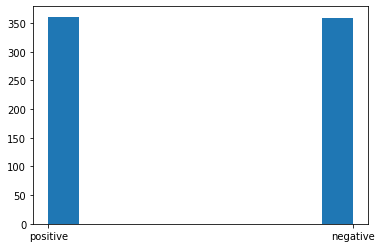

In [14]:
# Visualize the distribution of the sentiments
plt.hist(dataset_labels)
plt.show()

In [15]:
# Hot encoding for the label classes
hot_encoding = pd.get_dummies(np.squeeze(dataset_labels))
classes = np.array(hot_encoding.columns).astype('str')
hot_encoding = tf.convert_to_tensor(hot_encoding)
dataset_labels = hot_encoding

### Make sure all tweet sets contain the same number of tweets

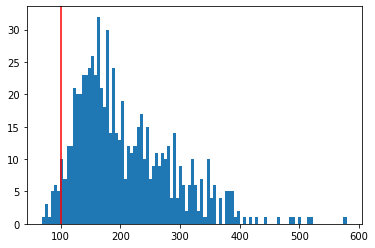

Total number of timewindows/ tweet_sets:  719
Number of discarded timewindows:  21


In [16]:
tweet_set_size = 100

# Visualize the distribution of the tweet sets sizes
plt.hist([tweet_set_df.shape[0] for tweet_set_df in dataset], bins=100)
plt.axvline(x=tweet_set_size, color="red")
plt.show()

print("Total number of timewindows/ tweet_sets: ", len(dataset))
print("Number of discarded timewindows: ", len([1 for tset in dataset if tset.shape[0] < tweet_set_size]))

In [17]:
# discard tweet sets (and respective labels) that have less than tweet_set_size tweets
remaining_dataset = []
remaining_dataset_labels = []
for i, tweet_set_df in enumerate(dataset):
    if tweet_set_df.shape[0] >= tweet_set_size:
        remaining_dataset.append(tweet_set_df)
        remaining_dataset_labels.append(dataset_labels[i])
dataset = remaining_dataset
dataset_labels = remaining_dataset_labels

In [18]:
def trim_tweet_set(tweet_set_df, goal_size):
    # tweets with higher like and follower counts are taken first
    tweet_set_df = tweet_set_df.sort_values(['likeCount','followersCount'])
    return tweet_set_df.tail(goal_size)

trim_tweet_set(dataset[0], tweet_set_size)

,content,replyCount,retweetCount,likeCount,quoteCount,verified,followersCount,friendsCount,statusesCount
date,,,,,,,,,
2022-01-01 00:40:33+00:00,the latest #bitcoin block 716607 with 5 transa...,0,0,1,0,False,322,234,23022
2022-01-01 00:55:33+00:00,the latest #bitcoin block 716609 with 1051 tra...,0,1,1,0,False,322,234,23022
2022-01-01 00:49:03+00:00,#twitter is at turning point since left. can a...,1,0,1,0,False,337,4952,2540
2022-01-01 00:17:33+00:00,happy new year fellow #bitcoin friends,0,0,1,0,False,375,647,2984
2022-01-01 00:47:32+00:00,energy sector and tech lobbyists will become ...,0,0,1,0,False,396,595,3928
...,...,...,...,...,...,...,...,...,...
2022-01-01 00:08:00+00:00,you cannot comprehend the strengths of #bitcoi...,44,54,136,4,False,116343,113,33734
2022-01-01 00:33:44+00:00,"""#binance has issued a notice to users, withou...",82,34,145,3,True,2428441,920,25770
2022-01-01 00:00:02+00:00,most people underestimate the impact #bitcoin ...,20,31,211,3,True,245622,750,18051


In [19]:
# trim tweet_sets that contain more than tweet_set_size tweets
dataset = [trim_tweet_set(tweet_set_df, tweet_set_size) for tweet_set_df in dataset]
print(len(dataset))
print(len(dataset_labels))
print(dataset[0].shape)
print(dataset[1].shape)

# All tweet sets must now have the same shape
assert all([tset.shape == dataset[0].shape for tset in dataset])
assert dataset[0].shape[0] == tweet_set_size

698
698
(100, 9)
(100, 9)


### Divide the tweets into text and metadata

In [20]:
X_texts = [tweet_set_df['content'].values for tweet_set_df in dataset]
X_texts = np.expand_dims(np.array(X_texts), axis=-1)
print(X_texts.shape) # number of tweet sets, number of tweets per set

(698, 100, 1)


In [21]:
metadata_columns = [
    'replyCount',
    'retweetCount',
    'likeCount',
    'quoteCount',
    'followersCount',
    'friendsCount',
    'statusesCount'
]
X_metadata = [tweet_set_df[metadata_columns].values for tweet_set_df in dataset]
X_metadata = np.array(X_metadata)
print(X_metadata.shape)

(698, 100, 7)


### Tokenize the tweet texts

In [22]:
# Must set flag "normalization=True" since we are using raw tweets
# This ensures that links, emojis etc. are properly encoded to serve as input for the Bertweet model
# Refer to: https://github.com/VinAIResearch/BERTweet
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True)
tokenizer(['Hello world this is a test !'], padding='max_length', truncation=True)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': [[0, 1659, 220, 33, 17, 11, 1156, 12, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
X_encodings = []
for tweet_set in X_texts:
    tweet_set_encoded = []
    for tweet_text in tweet_set:
        text_encoding = tokenizer(tweet_text.astype('str')[0], padding='max_length',
                                  truncation=True)
        tweet_set_encoded.append(text_encoding)
    X_encodings.append(tweet_set_encoded)

X_texts_input_ids = []
X_texts_attention_masks = []
X_texts_token_type_ids = []
for tweet_set in X_encodings:
    tweet_set_input_ids = []
    tweet_set_attention_masks = []
    tweet_set_token_type_ids = []
    for tweet_text in tweet_set:
        tweet_set_input_ids.append(tweet_text["input_ids"])
        tweet_set_attention_masks.append(tweet_text["attention_mask"])
        tweet_set_token_type_ids.append(tweet_text["token_type_ids"])
    X_texts_input_ids.append(tweet_set_input_ids)
    X_texts_attention_masks.append(tweet_set_attention_masks)
    X_texts_token_type_ids.append(tweet_set_token_type_ids)

### Extract text features using the bertweet model (WARNING: takes a LOT of time without GPU)

In [24]:
# Last step: extract text features using the bertweet model

bertwitter_encoder_model = TFAutoModel.from_pretrained("vinai/bertweet-base")

X_texts_features = []
for i in range(len(X_texts_input_ids)):
    print(i)
    bert_encoding = bertwitter_encoder_model(
        input_ids = tf.convert_to_tensor(X_texts_input_ids[i]),
        attention_mask = tf.convert_to_tensor(X_texts_attention_masks[i]),
        token_type_ids = tf.convert_to_tensor(X_texts_token_type_ids[i])
    )
    X_texts_features.append(bert_encoding['pooler_output'])

Downloading:   0%|          | 0.00/705M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Final data preparation steps

In [25]:
# Shuffle the dataset
dataset_size = len(dataset_labels)
shuffler = np.random.permutation(dataset_size)

X_texts_features = np.array(X_texts_features)[shuffler]
X_metadata = np.array(X_metadata)[shuffler]
dataset_labels = np.array(dataset_labels)[shuffler]

# Convert to tf tensors
X_texts_features = tf.convert_to_tensor(X_texts_features)
X_metadata = tf.convert_to_tensor(X_metadata)
labels = tf.convert_to_tensor(dataset_labels)

In [26]:
# Split dataset into training and testing set
test_ratio = 0.15
test_size = int(test_ratio * dataset_size)
train_size = dataset_size - test_size

X_train = [X_texts_features[:train_size], X_metadata[:train_size]]
y_train = labels[:train_size]
X_test = [X_texts_features[train_size:], X_metadata[train_size:]]
y_test = labels[train_size:]

In [27]:
print(X_train[0].shape)
print(X_train[1].shape)
print(y_train.shape)
print(X_test[0].shape)
print(X_test[1].shape)
print(y_test.shape)

(594, 100, 768)
(594, 100, 7)
(594, 2)
(104, 100, 768)
(104, 100, 7)
(104, 2)


# 4. Build the model

In [28]:
# We noticed that after some epochs of training, we get a 'nan' loss.
# After lots of research and debugging, we managed to solve the issue by adding epsilon.
# We believe that the issue was caused by the ReLu layer before the softmax layer:
# When input to ReLu is negative ==> it's output is 0 ==> scores equals 0
# ==> the weighted average layer divides by 0 ==> final output is 'nan'
epsilon = 0.001

# If threshhold == 0: binary classification ('positive' or 'negative')
# If threshhold > 0: classification with 3 classes (includes 'neutral')
output_units = 2 if price_movement_threshhold == 0 else 3

class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightedAverageLayer, self).__init__()

    def build(self, input_shape):
        return

    def call(self, inputs):
        values, scores = inputs
        scores = scores + epsilon
        values = values + epsilon
        return tf.reduce_sum(values * scores, axis=-2) / tf.reduce_sum(scores, axis=-2)

# We use 2 output units (hot_encoded categories) with softmax
#     instead of a single output unit with sigmoid.
# This is believed to yield a better accuracy
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.individual_classifier = tf.keras.layers.Dense(output_units,
                                        activation="softmax", name="individual-classifier")
        self.hidden_scorer_layer = tf.keras.layers.Dense(64, activation="relu")
        self.scorer = tf.keras.layers.Dense(1, activation="sigmoid", name="scorer")
        self.averaging_layer = WeightedAverageLayer()

    def call(self, inputs):
        # text_features.shape = (None, tweet_set_size, 768)
        # metadatas.shape = (None, tweet_set_size, 7)
        text_features, metadatas = inputs

        # Compute individual tweet sentiments
        features = self.dropout(text_features)
        sentiments = self.individual_classifier(features)

        # Compute individual tweet scores
        hidden = self.hidden_scorer_layer(metadatas)
        scores = self.scorer(hidden)

        # Perform a weighted average over individual tweet sentiments according to
        # their respective scores
        output = self.averaging_layer((sentiments, scores))
        return output

In [29]:
model = CustomModel()

model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [30]:
# NB: The model runs significantly faster with CPU vs with GPU

history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=1,
    validation_data=(X_test, y_test)
)

Epoch 1/1000
594/594 [==============================] - 4s 4ms/step - loss: 0.7216 - accuracy: 0.5253 - val_loss: 0.6931 - val_accuracy: 0.5192
Epoch 2/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7109 - accuracy: 0.5505 - val_loss: 0.7381 - val_accuracy: 0.5192
Epoch 3/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7191 - accuracy: 0.5051 - val_loss: 0.7126 - val_accuracy: 0.4808
Epoch 4/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7058 - accuracy: 0.5185 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 5/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7177 - accuracy: 0.5387 - val_loss: 0.8036 - val_accuracy: 0.4808
Epoch 6/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7259 - accuracy: 0.4966 - val_loss: 0.7306 - val_accuracy: 0.4808
Epoch 7/1000
594/594 [==============================] - 2s 4ms/step - loss: 0.7393 - accuracy: 0.4714 - val_loss: 0.6948 - val_accuracy:

In [ ]:
"""
Unfortuanetly the model didn't perform as expected. It didn't converge to the right 'behavior'. 
The loss over the training set continued to decrease. However we didn't notice any significant
decrease in the validation loss. Same thing with the accuracy metrics.

- One main reason for this is the lack of computational ressources. We didn't manage to train on more
than 1000 data point. This is equivalent to 1000 tweet sets. Each of those sets contains more than 100 tweets.
So maybe the model needs more training data to finally deduce the relation between single tweet sentiments
and aggregated market sentiments.

- Also we did not get rid of spam or tweets that don't bear much information. Our reasoning was that
the scoring layer should take care of all of that. If a tweet has only a minimal impact on the overall
market, then the model would notice that and only assign a tiny score to that tweet. therefore it
wouldn't be necessary to remove the tweet manually from our dataset.

- The labels that we collected can also play a role in the results we got.
Collecting the true labels relies heavily on many hyperparameters, such as the sizes of the time windows
and the price movement lag etc. However, again because of the lack of computing ressources,
we didn't manage to do any serious hyperparameter optimization.

- Furthermore, we don't finetune the bertweet encoder during the training process.
Here the reason are again computational ressources, since a single pass forward over the bertweet model
using our dataset takes already a few hours with CPU. Even using the GPUs from google colab, it's only
possible to do it in 30 minutes, when using a dataset containing just a 1000 data points. So if we want
to finetune the bertweet model, a single epoch will take at least 30 minutes, if we use gpu and restrain
ourselves to just 1000 data points.

- We haven't found any theory/ results in the literature that support our model. So it remains unclear,
whether such a model can converge at all.
"""